# INFO 2950 Final Project - Phase II
##### Janice Shen (js3678), Khai Xin Kuan (kk996), Sandy Lin (sl2534), David Park (yp358)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
import duckdb
import requests
from bs4 import BeautifulSoup
import time

## Research Questions
Something we found in common between the four of us is our love for music and aspiration in finance. We wondered, can something as personal as individual music preference be somehow related to the greater US economy. This conversation sparked us to research into previous work about music sentiments and the us economy, which seems to give us very promising correlation (such as music sentiment with weekly equity: https://www.sciencedirect.com/science/article/pii/S0304405X21003718#:~:text=We%20find%20that%20music%20sentiment,when%20trading%20restrictions%20limit%20arbitrage).

However, excited as we are, we ask a range of questions, from daring to more pessimistic:

1. Can we predict the valence (a spectrum indicating negative or positive emotions, with 0 indicating most negative and 1 indicating most positive) of the general population’s music preference based on the unemployment rate, fed fund rate and other economic variables?
2. Through this journey, we also wondered how danceability correlated with valence, and subsequently, can we predict the danceability (with 0.0 being the least danceable and 1.0 being the most danceable) of the general population’s music preference based on the unemployment rate, fed fund rate and other economic variables?

Originally, we went and included all songs in our analysis and found the correlation to be extremely weak. We wondered if this was because the data included a large quantity of songs but people didn't listen to some of them, making them irrelevant. Therefore, we revised our data and filter out unpopular songs with a metric of popularity (a scale out of 100, 100 being the most popular), creating a bottleneck of 70 for our top 10000 song data. 

Even then, we saw a weak correlation and wondered if there even is a relation betwen broad music/entertainment with the economy. Does the way people consumer entertainment effect the economy at all? Thus, coming to our final research question:

3. Lastly, taking a huge step back, is there any relationship between the music industry and the economy? More specifically, we ask is there any relation between the GDP and the music/entertainment growth?

In [2]:
#load all datasets
musicdata = pd.read_csv("data.csv")
econdata = pd.read_csv("index.csv")
undata= pd.read_csv("un.csv")
songdata=pd.read_csv("top10000song.csv")
us_gdp_data = pd.read_csv("GDP.csv")
us_entertainmentgdp_data = pd.read_csv("USPRFRMSPRTMSMNGSP.csv")

## Data Cleaning

We collected and identified popular music by identifying relevant variables to analyze the music sentiment of popular songs throughout the years. Such variables included danceability, valence, year, and popularity. 


### Checking Music Data and Handling Missing Values

In the music dataset(musicdata), we checked to see if Nan was present in any of our interested variables (danceability and valence) and whether actions needed to be taken to handle any missing values. We first checked the songs that have the valence datapoint and whether any songs have nan for valence. We then checked the songs that have the danceability data points and whether any songs have nan for danceability. 

In [3]:
# checking to see if we have NaN values
print("Number of music valence: ", len(musicdata['valence']))
print("Nan is present: ",\
      np.isnan(musicdata['valence']).any())

Number of music valence:  169909
Nan is present:  False


In [4]:
# checking to see if we have NaN values
print("Number of music danceability: ", len(musicdata['danceability']))
print("Nan is present: ",\
      np.isnan(musicdata['danceability']).any())

Number of music danceability:  169909
Nan is present:  False


### Gathering Popular Songs From Music Data

Popularity measures the popularity of the track within the music dataset. However, since the dataset is so large, we wanted basic stats on the dataset, including the mean, mode, and median. These data allows us to see which number occurs the most and if there is any skewness in the popularity of the average song. 

In [5]:
#check the mean, mode and median of songs' popularity
print(musicdata['popularity'].mean())
print(musicdata['popularity'].mode())
print(musicdata['popularity'].median())

31.55660971461194
0    0
Name: popularity, dtype: int64
33.0


### Cleaned Music Data

We cleaned the data and made a dataframe containing only the variables that we are interested in such as year, danceability, valence, and songs above a certain level of popularity. As indicated by the mode from the above statistics, the popularity of 0 is the most common occurrence with the songs in the dataset. Therefore, we wanted to filter out the popular songs more indicative of the general public's music preference rather than also include music enjoyed by few individuals. However, at the same time, we don't want our dataset to be too small. Therefore, we initially chose to filter out songs that have a popularity of at least 70. 

In [6]:
newmusicdata= duckdb.sql("SELECT danceability, valence, year, popularity FROM musicdata WHERE popularity>=70").df()
newmusicdata

,danceability,valence,year,popularity
0,0.704,0.636,2007,72
1,0.816,0.886,2012,70
2,0.394,0.441,2015,71
3,0.496,0.239,2015,70
4,0.663,0.678,2016,70
...,...,...,...,...
4536,0.636,0.506,2020,74
4537,0.618,0.359,2020,71
4538,0.875,0.306,2020,75
4539,0.514,0.153,2020,70


### Analyzing and analyzing uneven distribution of song Data

We wanted to check how the songs are distributed across the years based on popularity, and we noticed a problem. There are very limited
number of data points of songs in the earlier years(based on popularity), while there are a lot more songs in recent years. 

In [7]:
# count the number of songs available for each year
songsinyear = duckdb.sql("SELECT COUNT(Year) AS Count, Year FROM \
            newmusicdata GROUP BY Year ORDER BY Count DESC").df()
songsinyear.head(64)

,Count,year
0,870,2019
1,708,2020
2,670,2018
3,410,2017
4,227,2016
...,...,...
59,1,1961
60,1,1959
61,1,1958
62,1,1960


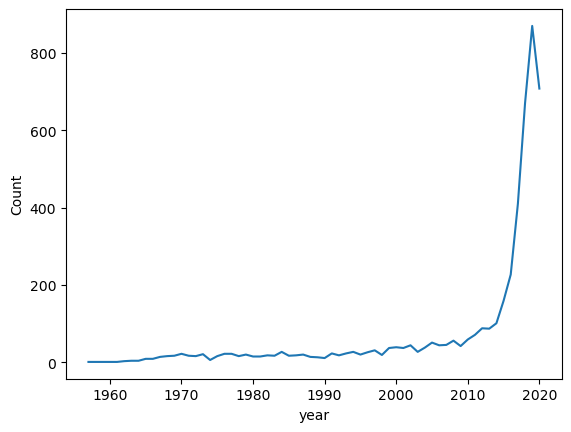

In [8]:
songsinyear_graph = sns.lineplot(songsinyear, x="year", y="Count")

As we have an uneven number of songs for each year, we thought it would cause some sort of issue with our analysis. 
Therefore, we decided to only include songs from 2000 to 2017 to address the uneven distribution.

In [9]:
newmusicdata = duckdb.sql("SELECT danceability, valence, year FROM newmusicdata WHERE year>=2000 AND year<=2017").df()
newmusicdata


,danceability,valence,year
0,0.704,0.636,2007
1,0.816,0.886,2012
2,0.394,0.441,2015
3,0.496,0.239,2015
4,0.663,0.678,2016
...,...,...,...
1620,0.589,0.604,2017
1621,0.446,0.474,2017
1622,0.684,0.647,2017
1623,0.656,0.452,2017


### Manipulating Econ Data and Handling Missing Values

We checked the Effective Federal Funds Rate for the number of data and checked to see if any missing values were present. 

In [10]:
# checking to see if we have NaN values
print("Number of rows in fed fund rate: ", len(econdata['Effective Federal Funds Rate']))
print("Nan is present: ",\
      np.isnan(econdata['Effective Federal Funds Rate']).any())

Number of rows in fed fund rate:  904
Nan is present:  True


To avoid any potential problems with graphs down the line, we dropped all the Nan values. After dropping all the Nans from our dataset, we then checked to see how many data points are now there. 

In [11]:
#Nan vaue is found, drop it 
econdata.dropna(subset=['Effective Federal Funds Rate'], inplace=True)
print(np.isnan(econdata['Effective Federal Funds Rate']).any())
#check the shape to see if we have enough data
print(econdata.shape)


False
(752, 10)


We renamed the 'Effective Federal Funds Rate' column in econdata to 'fedfundrate' to simplify every time we have to refer to the specific column 

In [12]:
#rename the Effective Federal Funds Rate col, easier without space for writing SQL later
print(econdata.columns)
econdata.rename(columns={"Effective Federal Funds Rate": "fedfundrate"}, inplace=True)
print(econdata.columns)

Index(['Year', 'Month', 'Day', 'Federal Funds Target Rate',
       'Federal Funds Upper Target', 'Federal Funds Lower Target',
       'Effective Federal Funds Rate', 'Real GDP (Percent Change)',
       'Unemployment Rate', 'Inflation Rate'],
      dtype='object')
Index(['Year', 'Month', 'Day', 'Federal Funds Target Rate',
       'Federal Funds Upper Target', 'Federal Funds Lower Target',
       'fedfundrate', 'Real GDP (Percent Change)', 'Unemployment Rate',
       'Inflation Rate'],
      dtype='object')


Since the fed fund rate is updated on a monthly basis, we averaged the fed fund rate over a 12 month period to get the average yearly fed fund rate. 

In [13]:
# modify econdata to find avg feadfundrate for each year
econdata = duckdb.sql("SELECT Year, AVG(fedfundrate) AS fedfundrate FROM econdata GROUP BY Year").df()
econdata

,Year,fedfundrate
0,1960,3.215833
1,1962,2.708333
2,1968,5.656667
3,1976,5.045000
4,1986,6.805000
...,...,...
59,1981,16.378333
60,1988,7.568333
61,2005,3.213333
62,2013,0.107500


### Checking and Manipulating Unemployment Data 

We checked the Unemployment data for the number of data points that were there and also see if any missing values were present. 

In [14]:
# checking to see if we have NaN values
print("Number of rows in UNRate: ", len(undata['UNRATE']))
print("Nan is present: ",\
      np.isnan(undata['UNRATE']).any())

Number of rows in UNRate:  921
Nan is present:  False


We converted date to datetime to allow for a more comprehensive merge later on. 

In [15]:
# in order to merge the data, we need to convert the date format into datetime

#check date type
print(undata["DATE"].dtype)
# convert to datetime format
undata['DATE']= pd.to_datetime(undata['DATE'], format='%Y-%m-%d', errors='coerce')
undata

object


,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
916,2024-05-01,4.0
917,2024-06-01,4.1
918,2024-07-01,4.3
919,2024-08-01,4.2


Since the unemployment rate data is given on a monthly scale, we averaged the 12-month unemployment to get a yearly average unemployment rate to allow the data to be merged with the Spotify dataset later on. 


In [16]:
# modify undata to find avg unrate for each year
newundata = duckdb.sql("SELECT year(DATE) AS Year, AVG(UNRATE) AS UnemploymentRate FROM undata GROUP BY year(DATE)").df()
newundata

,Year,UnemploymentRate
0,1951,3.283333
1,1960,5.541667
2,1962,5.566667
3,1968,3.558333
4,1976,7.700000
...,...,...
72,1967,3.841667
73,1975,8.475000
74,1977,7.050000
75,2006,4.608333


### Renaming US GDP 

We checked the Effective Federal Funds Rate for the number of data and checked to see if any missing values are present. 

In [17]:
# rename entertainmentgdp col for easier reference
us_gdp_data = us_gdp_data.rename(columns={"GDP": "US_GDP"})
us_gdp_data

,DATE,US_GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742
...,...,...
305,2023-04-01,27453.815
306,2023-07-01,27967.697
307,2023-10-01,28296.967
308,2024-01-01,28624.069


### Renaming Entertainment GDP

Since the entertainment GDP has a random name, we renamed the dataset to entertainment_GDP for easier reference later on. 

In [18]:
# rename entertainmentgdp col for easier reference
us_entertainmentgdp_data = us_entertainmentgdp_data.rename(columns={"USPRFRMSPRTMSMNGSP": "Entertainment_GDP"})
us_entertainmentgdp_data

,DATE,Entertainment_GDP
0,1997-01-01,37156.0
1,1998-01-01,40614.0
2,1999-01-01,44509.0
3,2000-01-01,49295.0
4,2001-01-01,51812.0
5,2002-01-01,56935.0
6,2003-01-01,61956.0
7,2004-01-01,65072.0
8,2005-01-01,67060.0
9,2006-01-01,73485.0


### Merging US GDP and Entertainment GDP 

We merged the total US_GDP with the Entertainment_GDP at a yearly scale on January 1st to see if there is a relationship between US_GDP and Entertainment_GDP. We want to confirm that the Entertainment GDP has a strong correlation with the US GDP. Since the Entertainment GDP and US GDP are different indicators, we want to see if music sentiment has any relationship with the US GDP at large vs its relationship with the entertainment GDP. 

In [19]:
# merge the 2 datasets tgt on date. (only interested in jan 1st since entertainmentgdp dataset only has jan 1st data
gdp_entgdp_df = pd.merge(us_gdp_data, us_entertainmentgdp_data, how="inner", on="DATE")


gdp_entgdp_df['DATE']= pd.to_datetime(gdp_entgdp_df['DATE'], format='%Y-%m-%d', errors='coerce')

gdp_entgdp_df = duckdb.sql("SELECT year(DATE) AS Year, US_GDP, Entertainment_GDP FROM gdp_entgdp_df").df()


gdp_entgdp_df
 

,Year,US_GDP,Entertainment_GDP
0,1997,8362.655,37156.0
1,1998,8866.480,40614.0
2,1999,9411.682,44509.0
3,2000,10002.179,49295.0
4,2001,10470.231,51812.0
5,2002,10783.500,56935.0
6,2003,11174.129,61956.0
7,2004,11923.447,65072.0
8,2005,12767.286,67060.0
9,2006,13599.160,73485.0


### Data Cleaning: Getting a comprehensive dataframe 


Next, we merged all of the data frames together to create one comprehensive overview of all the present information. We merged the data frame with the music sentiment(danceability, valence, year) with the fedfundrate dataframe, unemploymentRate dataframe, and the GDP dataframe. This allows us to see how certain economic metrics affect the music sentiment shared by the general public. 

In [20]:
# use sql to get a data frame with danceabilty, valence, interest rate and unemployment
cleandata= duckdb.sql("SELECT danceability,valence, \
            newmusicdata.year, fedfundrate FROM\
            newmusicdata INNER JOIN econdata ON \
            newmusicdata.year = econdata.Year").df()
cleandata= duckdb.sql("SELECT danceability,valence, \
            cleandata.year, \
            fedfundrate, UnemploymentRate FROM cleandata INNER JOIN newundata\
            ON cleandata.year = newundata.Year").df()
cleandata= duckdb.sql("SELECT danceability,valence, \
        cleandata.year, \
        fedfundrate, UnemploymentRate, US_GDP, Entertainment_GDP FROM cleandata INNER JOIN gdp_entgdp_df\
        ON cleandata.year = gdp_entgdp_df.year").df()
cleandata

,danceability,valence,year,fedfundrate,UnemploymentRate,US_GDP,Entertainment_GDP
0,0.704,0.636,2007,5.019167,4.616667,14215.651,75604.0
1,0.816,0.886,2012,0.140000,8.075000,16068.805,101755.0
2,0.394,0.441,2015,0.132500,5.275000,18063.529,111486.0
3,0.496,0.239,2015,0.132500,5.275000,18063.529,111486.0
4,0.663,0.678,2016,0.395000,4.875000,18525.933,120037.0
...,...,...,...,...,...,...,...
1620,0.589,0.604,2017,0.655000,4.358333,19280.084,126803.0
1621,0.446,0.474,2017,0.655000,4.358333,19280.084,126803.0
1622,0.684,0.647,2017,0.655000,4.358333,19280.084,126803.0
1623,0.656,0.452,2017,0.655000,4.358333,19280.084,126803.0


### Correlation visualization and analysis


Using the large data frame that contains all relevant information about both the music sentiments and the economic metrics, we made a correlation matrix, examining the correlation of how and if certain economic variables correspond with a certain change in music sentiments. 

The correlation matrix reveals no strong relationship between music sentiment and different economic factors. 

The strongest relationship is between US GDP and valence with a negative correlation of -0.2. Valence and fedfundrate also have a weak positive relationship of 0.13. Valence and the Unemployment rate have a weak positive relationship of 0.09. 


The correlation is even worse for danceability, where the correlation between danceability and all other economic metrics (fedfundrate, unemployment rate, and US GDP) are < 0.05. 

In [21]:
# inspect the correlation
cleandata.corr()

,danceability,valence,year,fedfundrate,UnemploymentRate,US_GDP,Entertainment_GDP
danceability,1.000000,0.414775,0.034248,-0.026313,-0.014176,0.033225,0.037870
valence,0.414775,1.000000,-0.206010,0.133153,0.092991,-0.208632,-0.203580
year,0.034248,-0.206010,1.000000,-0.699514,-0.208228,0.995226,0.995377
fedfundrate,-0.026313,0.133153,-0.699514,1.000000,-0.361399,-0.639191,-0.673545
UnemploymentRate,-0.014176,0.092991,-0.208228,-0.361399,1.000000,-0.284991,-0.261601
US_GDP,0.033225,-0.208632,0.995226,-0.639191,-0.284991,1.000000,0.993423
Entertainment_GDP,0.037870,-0.203580,0.995377,-0.673545,-0.261601,0.993423,1.000000


### Plotting To Visualize the Trends Between Different Music Variables Vs Different Economic Variables

We want to visualize how valence trends with danceability over time to observe any peculiarities that may have skewed the correlation result. As observed in the correlation matrix above, we saw that the correlation between valence and danceability is 0.41, which was surprising as we expected it to be higher. Therefore, we plotted it to if the direction that both variables moved were always different or if there was something else going on. From the graph, we can see that the overall trend between danceability and valence is mostly similar, except for the period from 2012 onwards, where danceability increases while valence decreases.

<Axes: xlabel='year', ylabel='valence'>

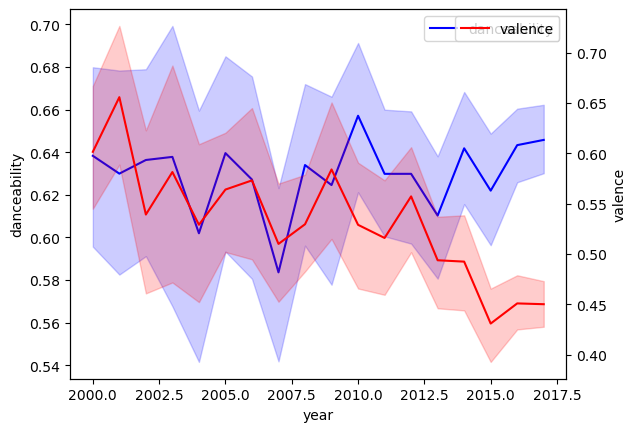

In [22]:
# visualize time series of valence and danceability across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='danceability', data=cleandata, ax=ax1, color='blue', label='danceability')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='valence', data=cleandata, ax=ax2, color='red', label='valence')

We then plotted fedfundrate against valence. Interestingly, we do observe fedfundrate and valence going in similar directions. However, the spikes for fedfundrate are a lot more extreme, with extreme ups and extreme downs. On the other hand, valence progresses a lot more steadily, with a steady decline over time. 

<Axes: xlabel='year', ylabel='valence'>

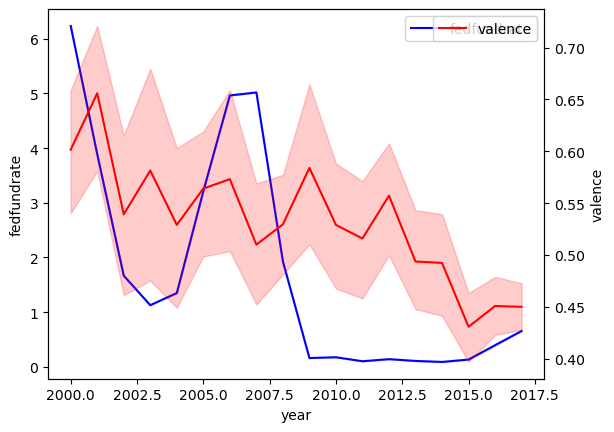

In [23]:
# visualize time series of valence and fedfundrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='fedfundrate', data=cleandata, ax=ax1, color='blue', label='fedfundrate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='valence', data=cleandata, ax=ax2, color='red', label='valence')

We then plotted fedfundrate against danceability. We don't observe any trend between the two variables. While Danceability remained stable, fedfundrate had a large spike, which later plummeted. 

<Axes: xlabel='year', ylabel='danceability'>

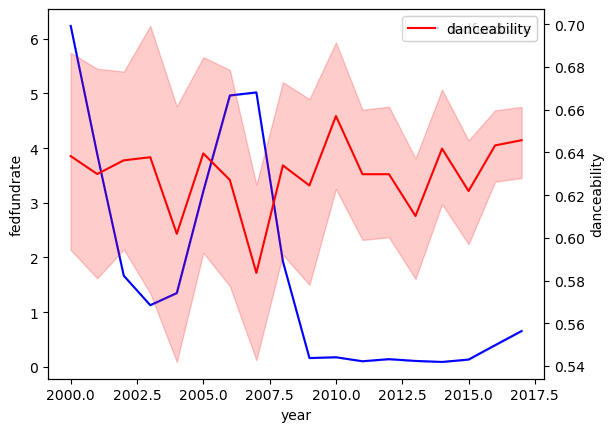

In [24]:
# visualize time series of danceability and fedfundrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='fedfundrate', data=cleandata, ax=ax1, color='blue', label='fedfundrate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='danceability', data=cleandata, ax=ax2, color='red', label='danceability')

Next, we looked at the relationship between the unemployment rate and valence. The plot doesn't seem to indicate any trends between unemployment Rate and valence Throughout the lineplot, valence seems to be steadily going down while the unemployment rate seems to be spiking up and down. 

<Axes: xlabel='year', ylabel='valence'>

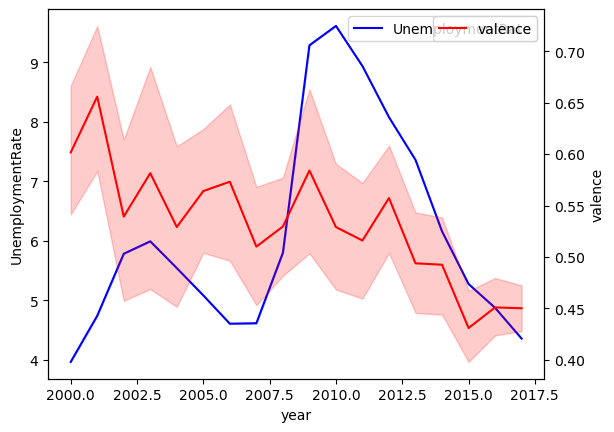

In [25]:
# visualize time series of valence and unemploymentrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='UnemploymentRate', data=cleandata, ax=ax1, color='blue', label='UnemploymentRate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='valence', data=cleandata, ax=ax2, color='red', label='valence')

We then plotted danceability with unemployment. Again, given the low correlation in the correlation matrix, these two factors interestingly look like they have a relationship. While unemployment spiked more severely over the years, with ups and downs, music danceability follows a similar trend but remains more steady around a small range. 

<Axes: xlabel='year', ylabel='danceability'>

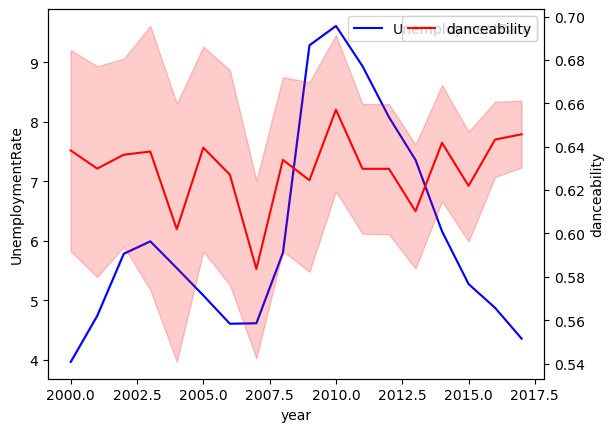

In [26]:
# visualize time series of danceability and unemploymentrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='UnemploymentRate', data=cleandata, ax=ax1, color='blue', label='UnemploymentRate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='danceability', data=cleandata, ax=ax2, color='red', label='danceability')

#### Music Data vs. US GDP

We then plotted danceability with US GDP. There appears to be no correlation as danceability remains stable, while US GDP increased throughout the year, danceability remains similar, oscillating slightly in the center. 

In [1]:
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='US_GDP', data=cleandata, ax=ax1, color='blue', label='US GDP')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='danceability', data=cleandata, ax=ax2, color='red', label='danceability')

NameError: name 'plt' is not defined

We then plotted valence with US GDP. There appears to be negative correlation. While valence steadily and slowly decreased over time, US GDP increased linearly over time. 

<Axes: xlabel='year', ylabel='valence'>

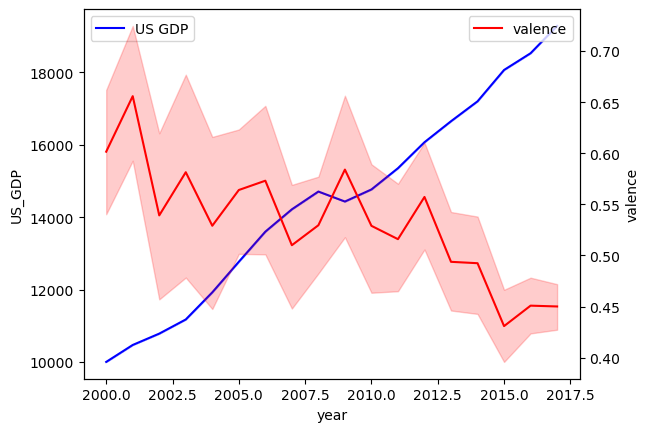

In [28]:
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='US_GDP', data=cleandata, ax=ax1, color='blue', label='US GDP')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='valence', data=cleandata, ax=ax2, color='red', label='valence')

### Scatterplot to Analyze Data points 

Inspect why dancebility and valence has such weak correlation with fedfundrate and unemploymentrate by plotting scatter plots. We found out that regardless of the fed fund rate and unemployment rate, we have songs with a full spectrum of danceability and valence. This might justify why there is a week correlation.

NOTE: we reduce the transparency of the dot to make sure we can determine overlapping to get more accurate perceptions of the fange of songs' danceability and valence.

Scatterplot for fedfundrate and danceability. Danceability seems to generally shift up (become higher) when interest rate increases. 

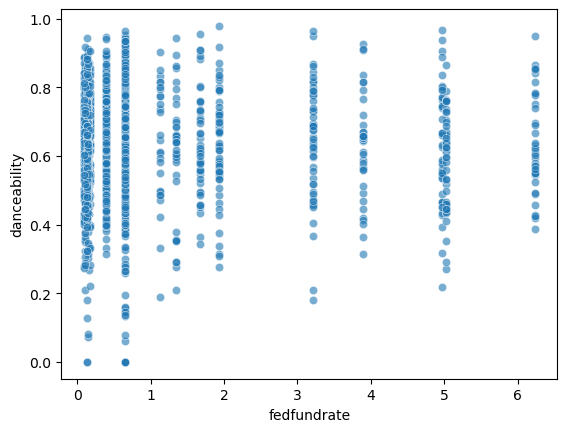

In [33]:
dance_fedfund_graph= sns.scatterplot(cleandata, x="fedfundrate", y="danceability", alpha=0.6)


Scatterplot for fedfundrate and valence. There appears to be a wide range of valence across all fedfundrate. 

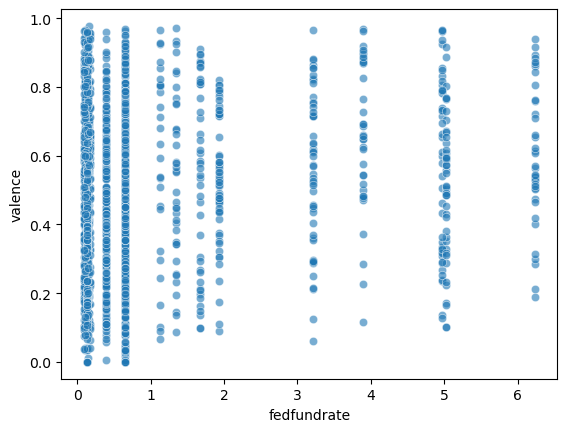

In [30]:
valence_fedfund_graph= sns.scatterplot(cleandata, x="fedfundrate", y="valence", alpha=0.6)

Scatterplot for unemployment rate and valence. There appears to be a wide range of danceability across all unemployment rate. However, the range of danceability seems to be slightly smaller when unemployment rate increases. 

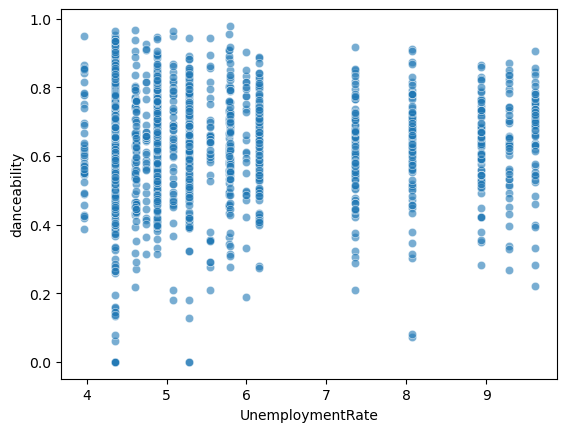

In [31]:
dance_un_graph= sns.scatterplot(cleandata, x="UnemploymentRate", y="danceability", alpha=0.6)

Scatterplot for unemployment rate and valence. There appears to be a wide range of valence across all unemployment rate.

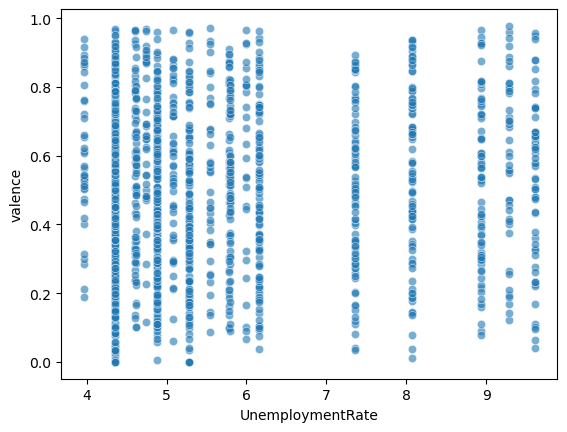

In [32]:
valence_un_graph= sns.scatterplot(cleandata, x="UnemploymentRate", y="valence", alpha=0.6)

END Khai 1.33pm (cells below are not needed, all cells are merged)

### Data Discussion
The first dataset from spotify  defines the popularity of a song from the current viewership  while the second data set (top 10000 songs) defines popularity from a historical perspective (how popular was a top hit during its age). In our context, the second dataset would be better suited since we are comparing the unemployment rate or interest rate of that period to the popularity of songs of that period. Thus, comparing historical economic data with current popularity could obscure our research. 

Secondly, we soon realized that the simple variables we picked actually turned out to be not so simple. The danceability and valence curve, the interest rate and unemployment rate curve are all complex measures that oscillate and spike in unpredictable trends. Thus, we tried to fit linear relationships to the data which was difficult. This may be due to the fact that many factors contribute to music consumption and sentiment, such as, changing music taste/consumption and current event (covid for example) that fundamentally changes how people behave and thus changing music preference and taste. For example, when people are employed, they are happier and consumer happier music (shown in data set 2 where unemployment rate has a negative correlation with valence in music) but in another perspective, when people are unemployment, the need more happy music (shown in data set 1, where unemployment rate has a positive correlation with valence in music). 

Lastly, we believe that due to the complex nature of virtually all the indicators we picked, we want to inspect more variables that would strengthen our model. Variables we have in mind are genres of music, socio-economics factors, other econ factors, music taste/preferences, and so on. 

### Data Limitations¶
One limitation is that the first spotify data set defines the popularity of a song from the current viewership perspective, making it not representative of historical data. 

Another limitation is that the unemployment raw data itself is missing some values that we dropped. Although this doesn’t affect greatly since we average the months of that year’s unemployment data, this could cause the average to be higher or lower due to the dropped month’s historical trend (for example, the february month could be usually lower than january data, making the overall yearly employment higher than it actually is). 

The spotify data set and 2nd song data (top10000 songs) set that we have represent the popularity globally. Couldn't find a dataset based on only the US population.

#### Questions
- Our data (see the graphs near the beginning) are very not linear friendly, how can we transform it or make sense of it?
- Given the low correlation and linear regression coefficient, is there a better model for us to train the data?
- How can we transform our model to better fit the data?
- How and do we have to cite resources?